## **Projeto Final**: Aprendizado de Máquina MC886

# **Detecção de Comentários Tóxicos em Português do Brasil:** Baseline com NBSVM

Universidade de Campinas (UNICAMP), Instituto da Computação (IC)

Prof. Sandra Avila, 2s2020

**Grupo**:
- Eduardo Barros Innarelli (170161)
- João Pedro Congio Martins (176117)
- Pedro Alan Tapia Ramos (185531)

---

Se você estiver usando o Google Colab, conecte com o Google Drive para ter acesso aos datasets:

In [1]:
from google.colab import drive

# Isso solicitará autorização
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Vá até a pasta do projeto (depende da onde está salva no seu Drive)
% cd '/content/drive/My Drive/[MC886] Projeto Final/'
! ls

/content/drive/My Drive/[MC886] Projeto Final
bertimbau.ipynb		 docs	     nbsvm_baseline.ipynb  __pycache__
build_nbsvm_pipeline.py  model_save  nbsvm-model.joblib    split_dataset.py
data			 nbsvm	     pretrained-bert	   tokenizer.py


---

## **Dependências**

In [3]:
# Para análise e manipulação de dados
import pandas as pd

# Produto cartesiano
from itertools import product

# Classe que permite treinar o modelo com grid search
from sklearn.model_selection import GridSearchCV

# Função que divide os dados em treino e teste
from split_dataset import split_dataset

# Função que constrói o pipeline de vetorização + treinamento
from build_nbsvm_pipeline import build_pipeline

# Classe que controla como os textos serão tokenizados 
from tokenizer import Tokenizer

# Para salvar e carregar o modelo em um arquivo 
from nbsvm.saving import save_model, load_model

# Funções que computam métricas
from sklearn.metrics import classification_report, confusion_matrix

# Para visualização dos dados
import matplotlib.pyplot as plt
import seaborn as sns

O tokenizador usa as stopwords do NLTK para aplicar stemização nos textos.

In [4]:
# Baixar stopwords do NLTK
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## **Pré-processamento**

Usamos a mesma estratégia do artigo base de agregar as classes de ofensa em uma única e classificar um tweet como tóxico se ao menos uma pessoa o anotou como tal em alguma das categorias.

> "In this paper, we consider the least restrictive case,
where if at least one annotator marked any offence
category in an example, the example is positive for
toxicity. Likewise, if a tweet was not tagged in any
of these categories, it is considered non-toxic. We
believe that it is essential that if any person feels
uncomfortable with a post, it should be flagged as
having a certain degree of toxicity. Therefore, a
model built with this data must be able to identify
offensive posts, even for a specific group of people."


In [5]:
# Carregar dataset
told_br = pd.read_csv("data/ToLD-BR.csv")

# Agregar classes de comentários ofensivos
told_br['toxic'] = told_br[['homophobia', 
                            'obscene',
                            'insult',
                            'misogyny',
                            'xenophobia']].agg('sum', axis=1)

# Converter em classificação binária (1 é tóxico, 0 não é tóxico)
told_br.loc[told_br['toxic'] >= 1, 'toxic'] = 1

Agora, dividimos o dataset em treino e teste. Não separamos um conjunto de validação pois utilizaremos um método do `scikit-learn` que já aplica validação cruzada.  

In [6]:
# Dividir dataset em treino e teste
train, test, _ = split_dataset(told_br,
                               test_size=0.1,
                               valid_size=0.0,
                               target_col_name='toxic',
                               random_state=42)

# Os conjuntos serão enviados para as funções do scikit-learn como arrays numpy
X_train, y_train = train['text'].values, train['toxic'].values
X_test, y_test = test['text'].values, test['toxic'].values

-->  Train size: 18900
-->  Valid size: 0
-->  Test size: 2100


## **Treinamento**

Instanciamos o pipeline de treinamento do modelo NBSVM, que transforma a entrada do modelo em uma matriz documento-termo com o `TfidfVectorizer`.  

In [ ]:
# Definir alguns hiperparâmetros de base para o pipeline
base_hparams = {'do_stem': True,
                'min_word_size': 4,
                'do_lower': True,
                'min_df': 0.1,
                'max_df': 0.85,
                'C': 1,
                'dual': True,
                'solver': 'liblinear',
                'max_iter': 1000}

# Instanciar pipeline
pipeline = build_pipeline(base_hparams)

Para treinar, adotaremos a técnica de otimização de hiperparâmetros intitulada grid search. O modelo será treinado com todas as possíveis combinações de hiperparâmetros definidos em `grid_params`, tal que o melhor modelo encontrado é salvo na classe. O método do `scikit-learn` também aplica validação cruzada, estratégia que ajuda a avaliar se o modelo generaliza bem.

In [ ]:
# Salvar todas as possíveis configurações do tokenizador
tokenizer_configs = []
for (do_stem, min_word_size) in product([True, False],  [3, 4, 5]):
    tokenizer_configs.append(
        Tokenizer(do_stem=do_stem, min_word_size=min_word_size).tokenize
    )

# Hiperparâmetros que serão otimizados
grid_params = {'vectorizer__lowercase': [True, False],
               'vectorizer__tokenizer': tokenizer_configs,
               'vectorizer__min_df': [3, 5, 10, 20],
               'vectorizer__max_df': [0.5, 0.65, 0.8, 0.95],
               'nbsvm__C': [1e-1, 1, 4, 10]}

# Grid search com validação cruzada
search = GridSearchCV(pipeline,
                      grid_params,
                      cv=5,
                      verbose=10,
                      error_score='raise')

Como são muitas combinações possíveis, o treinamento pode demorar bastante.

**ATENÇÃO:** evite rodar esta célula caso o modelo já tenha sido treinado! Carregue do arquivo nas próximas células ou re-treine com os melhores hiperparâmetros encontrados. 

In [ ]:
# Treinar com grid search
search.fit(X_train, y_train)
print('Grid search finalizado!')
print('--> Melhor score:', search.best_score_)
print('--> Melhores hiperparâmetros:', search.best_params_)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
[CV] nbsvm__C=0.1, vectorizer__lowercase=True, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__tokenizer=<bound method Tokenizer.tokenize of <Tokenizer do_stem:True min_word_size:3>> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  nbsvm__C=0.1, vectorizer__lowercase=True, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__tokenizer=<bound method Tokenizer.tokenize of <Tokenizer do_stem:True min_word_size:3>>, score=0.695, total=  11.5s
[CV] nbsvm__C=0.1, vectorizer__lowercase=True, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__tokenizer=<bound method Tokenizer.tokenize of <Tokenizer do_stem:True min_word_size:3>> 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.5s remaining:    0.0s


[CV]  nbsvm__C=0.1, vectorizer__lowercase=True, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__tokenizer=<bound method Tokenizer.tokenize of <Tokenizer do_stem:True min_word_size:3>>, score=0.691, total=  11.5s
[CV] nbsvm__C=0.1, vectorizer__lowercase=True, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__tokenizer=<bound method Tokenizer.tokenize of <Tokenizer do_stem:True min_word_size:3>> 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.0s remaining:    0.0s


[CV]  nbsvm__C=0.1, vectorizer__lowercase=True, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__tokenizer=<bound method Tokenizer.tokenize of <Tokenizer do_stem:True min_word_size:3>>, score=0.690, total=  11.4s
[CV] nbsvm__C=0.1, vectorizer__lowercase=True, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__tokenizer=<bound method Tokenizer.tokenize of <Tokenizer do_stem:True min_word_size:3>> 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   34.4s remaining:    0.0s


[CV]  nbsvm__C=0.1, vectorizer__lowercase=True, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__tokenizer=<bound method Tokenizer.tokenize of <Tokenizer do_stem:True min_word_size:3>>, score=0.683, total=  11.4s
[CV] nbsvm__C=0.1, vectorizer__lowercase=True, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__tokenizer=<bound method Tokenizer.tokenize of <Tokenizer do_stem:True min_word_size:3>> 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   45.8s remaining:    0.0s


[CV]  nbsvm__C=0.1, vectorizer__lowercase=True, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__tokenizer=<bound method Tokenizer.tokenize of <Tokenizer do_stem:True min_word_size:3>>, score=0.681, total=  11.6s
[CV] nbsvm__C=0.1, vectorizer__lowercase=True, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__tokenizer=<bound method Tokenizer.tokenize of <Tokenizer do_stem:True min_word_size:4>> 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   57.4s remaining:    0.0s


[CV]  nbsvm__C=0.1, vectorizer__lowercase=True, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__tokenizer=<bound method Tokenizer.tokenize of <Tokenizer do_stem:True min_word_size:4>>, score=0.664, total=  11.3s
[CV] nbsvm__C=0.1, vectorizer__lowercase=True, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__tokenizer=<bound method Tokenizer.tokenize of <Tokenizer do_stem:True min_word_size:4>> 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.1min remaining:    0.0s


[CV]  nbsvm__C=0.1, vectorizer__lowercase=True, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__tokenizer=<bound method Tokenizer.tokenize of <Tokenizer do_stem:True min_word_size:4>>, score=0.668, total=  11.2s
[CV] nbsvm__C=0.1, vectorizer__lowercase=True, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__tokenizer=<bound method Tokenizer.tokenize of <Tokenizer do_stem:True min_word_size:4>> 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  1.3min remaining:    0.0s


[CV]  nbsvm__C=0.1, vectorizer__lowercase=True, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__tokenizer=<bound method Tokenizer.tokenize of <Tokenizer do_stem:True min_word_size:4>>, score=0.654, total=  11.3s
[CV] nbsvm__C=0.1, vectorizer__lowercase=True, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__tokenizer=<bound method Tokenizer.tokenize of <Tokenizer do_stem:True min_word_size:4>> 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.5min remaining:    0.0s


[CV]  nbsvm__C=0.1, vectorizer__lowercase=True, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__tokenizer=<bound method Tokenizer.tokenize of <Tokenizer do_stem:True min_word_size:4>>, score=0.664, total=  11.2s
[CV] nbsvm__C=0.1, vectorizer__lowercase=True, vectorizer__max_df=0.5, vectorizer__min_df=3, vectorizer__tokenizer=<bound method Tokenizer.tokenize of <Tokenizer do_stem:True min_word_size:4>> 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.7min remaining:    0.0s


A saída de streaming foi truncada nas últimas 5000 linhas.
[CV] nbsvm__C=1, vectorizer__lowercase=True, vectorizer__max_df=0.95, vectorizer__min_df=3, vectorizer__tokenizer=<bound method Tokenizer.tokenize of <Tokenizer do_stem:False min_word_size:4>> 
[CV]  nbsvm__C=1, vectorizer__lowercase=True, vectorizer__max_df=0.95, vectorizer__min_df=3, vectorizer__tokenizer=<bound method Tokenizer.tokenize of <Tokenizer do_stem:False min_word_size:4>>, score=0.710, total=   1.1s
[CV] nbsvm__C=1, vectorizer__lowercase=True, vectorizer__max_df=0.95, vectorizer__min_df=3, vectorizer__tokenizer=<bound method Tokenizer.tokenize of <Tokenizer do_stem:False min_word_size:4>> 
[CV]  nbsvm__C=1, vectorizer__lowercase=True, vectorizer__max_df=0.95, vectorizer__min_df=3, vectorizer__tokenizer=<bound method Tokenizer.tokenize of <Tokenizer do_stem:False min_word_size:4>>, score=0.724, total=   1.2s
[CV] nbsvm__C=1, vectorizer__lowercase=True, vectorizer__max_df=0.95, vectorizer__min_df=3, vectorizer__token

[Parallel(n_jobs=1)]: Done 3840 out of 3840 | elapsed: 406.0min finished


Grid search finalizado!
--> Melhor score: 0.7319642857142858
--> Melhores hiperparâmetros: {'nbsvm__C': 4, 'vectorizer__lowercase': True, 'vectorizer__max_df': 0.5, 'vectorizer__min_df': 3, 'vectorizer__tokenizer': <bound method Tokenizer.tokenize of <Tokenizer do_stem:False min_word_size:3>>}


Os hiperparâmetros que retornaram o melhor modelo foram:



```
{
  'nbsvm__C': 4, 
  'vectorizer__lowercase': True, 
  'vectorizer__max_df': 0.5, 
  'vectorizer__min_df': 3, 
  'vectorizer__tokenizer': <bound method Tokenizer.tokenize of <Tokenizer do_stem:False min_word_size:3>>
}
```



Salvamos o melhor modelo em um arquivo `joblib` para não precisar re-treinar.

In [ ]:
# Salvar modelo
save_model('nbsvm-model.joblib', search.best_estimator_)

## **Avaliação**

Primeiro, carregamos o modelo salvo no arquivo `nbsvm-model.joblib`.

In [7]:
model = load_model('nbsvm-model.joblib')

Vamos avaliar como o modelo generaliza pro conjunto de testes.

In [8]:
# Predizer no conjunto de testes
preds = [pred for pred in model.predict(X_test)]

# Mostrar métricas
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.73      0.80      0.77      1179
         1.0       0.71      0.62      0.66       921

    accuracy                           0.72      2100
   macro avg       0.72      0.71      0.71      2100
weighted avg       0.72      0.72      0.72      2100



Finalmente, plotamos a matriz de confusão para termos uma visão melhor dos acertos e erros do modelo treinado.

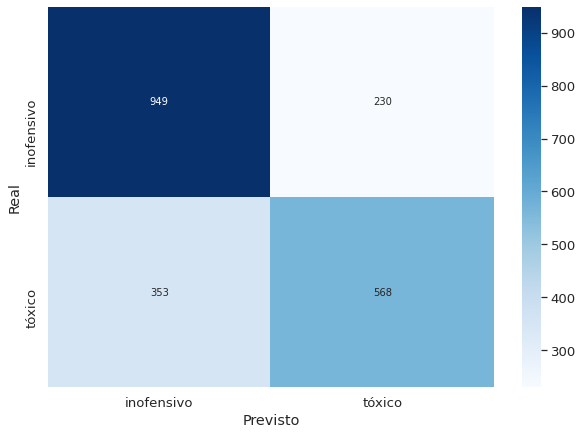

In [9]:
# Construir matriz de confusão com scikit-learn
cmatrix = confusion_matrix(y_test, preds)

# Salvar matriz como um dataframe do pandas
labels = ['inofensivo', 'tóxico']
df_cm = pd.DataFrame(cmatrix, columns=labels, index=labels)
df_cm.index.name = 'Real'
df_cm.columns.name = 'Previsto'

# Plotar como um mapa de calor
plt.figure(figsize = (10,7))
sns.set(font_scale=1.2)
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 10}, fmt='g');